In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
#from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

/Users/nikita/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
btc = pd.read_csv('/Users/nikita/Desktop/monero/BTC.csv', sep=',', encoding='utf-8')

In [8]:
btc['close'] = btc['close'].str.replace('.', '')
btc['high'] = btc['high'].str.replace('.', '')
btc['low'] = btc['low'].str.replace('.', '')
btc['open'] = btc['open'].str.replace('.', '')
btc['volume'] = btc['volume'].str.replace('.', '')

btc['close'] = btc['close'].str.replace(',', '.').astype(float)
btc['high'] = btc['high'].str.replace(',', '.').astype(float)
btc['low'] = btc['low'].str.replace(',', '.').astype(float)
btc['open'] = btc['open'].str.replace(',', '.').astype(float)
btc['volume'] = btc['volume'].str.replace(',', '.')  # Remove commas

btc['volume'] = btc['volume'].str.replace('K', 'e3')  # Replace 'K' with 'e3'
btc['volume'] = btc['volume'].str.replace('M', 'e6')  # Replace 'M' with 'e6'
btc['volume'] = btc['volume'].str.replace('B', 'e9')  # Replace 'B' with 'e9'
btc['volume'] = btc['volume'].astype(float)  # Convert to float

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11052/493286543.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['close'] = btc['close'].str.replace('.', '')
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11052/493286543.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['high'] = btc['high'].str.replace('.', '')
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11052/493286543.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['low'] = btc['low'].str.replace('.', '')
/var

In [9]:
btc

,date,close,high,low,open,volume
0,27.09.2012,12.3,12.3,12.4,12.2,19330.0
1,28.09.2012,12.4,12.3,12.4,12.1,26680.0
2,29.09.2012,12.4,12.4,12.5,12.2,17060.0
3,30.09.2012,12.4,12.4,12.4,12.3,7790.0
4,01.10.2012,12.4,12.4,12.5,12.3,24830.0
...,...,...,...,...,...,...
4591,23.04.2025,93697.7,93442.2,94462.6,91963.4,90350.0
4592,24.04.2025,93980.3,93696.3,94001.0,91673.0,66680.0
4593,25.04.2025,94676.9,93979.4,95718.6,92867.2,92040.0
4594,26.04.2025,94631.4,94669.3,95207.0,93891.8,33770.0


In [10]:
num_shape = 4000

train = btc['close'].iloc[:num_shape].values
test = btc['close'].iloc[num_shape:].values

In [11]:
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

In [12]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)


In [13]:
X_train = []

# Цена на следующий день
y_train = []

# Выбираем ширину окна, т.е. длину входного вектора
window = 30

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)
X_train.shape

(3970, 30, 1)

# Прогнозирование с помощью рекуррентных блоков LSTM и GRU

In [13]:
# Initializing the Recurrent Neural Network
model = tensorflow.keras.Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 16, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 8))
model.add(Dropout(0.2))


# Adding the output layer
model.add(Dense(units = 1))
model.summary()

/Users/nikita/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,329 (516.91 KB)

 Trainable params: 132,329 (516.91 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0133 - mae: 0.0653
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0046 - mae: 0.0383
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0047 - mae: 0.0375
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0039 - mae: 0.0336
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0025 - mae: 0.0303
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0030 - mae: 0.0323
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0029 - mae: 0.0326
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0029 - mae: 0.0324
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - mae: 0.0330
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0026 - mae: 0.0310
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0031 - mae: 0.0337
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0027 - mae: 0.0332
E

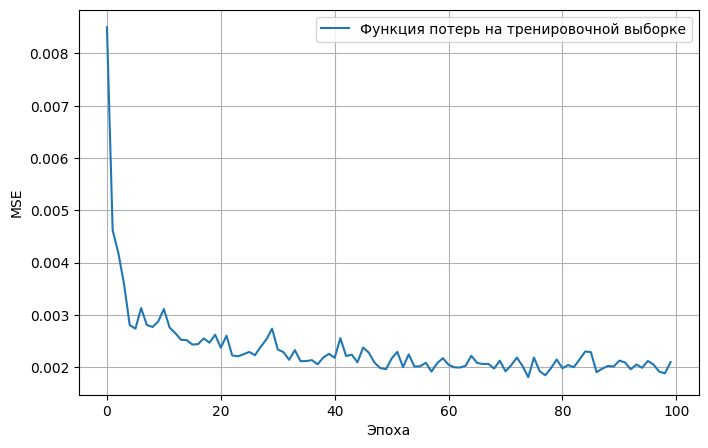

In [16]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['loss'], label='Функция потерь на тренировочной выборке')
#plt.plot(hist.history['val_loss'], label='Функция потерь на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

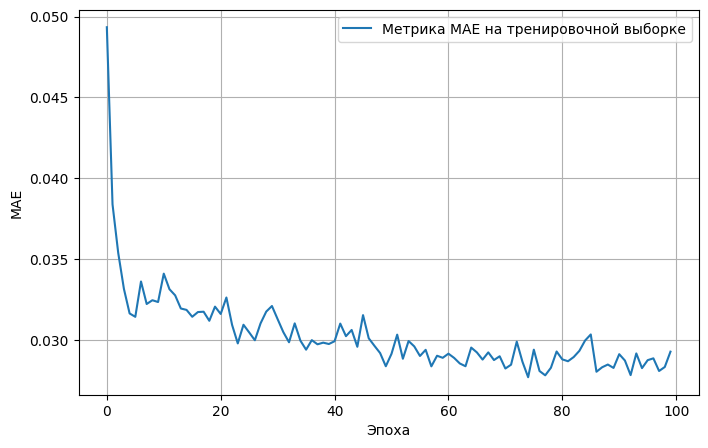

In [17]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['mae'], label='Метрика MAE на тренировочной выборке')
#plt.plot(hist.history['val_mae'], label='Метрика MAE на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)

X_test = np.stack(X_test)

In [19]:
predict_LSTM = model.predict(X_test)
predict_LSTM = scaler.inverse_transform(predict_LSTM)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


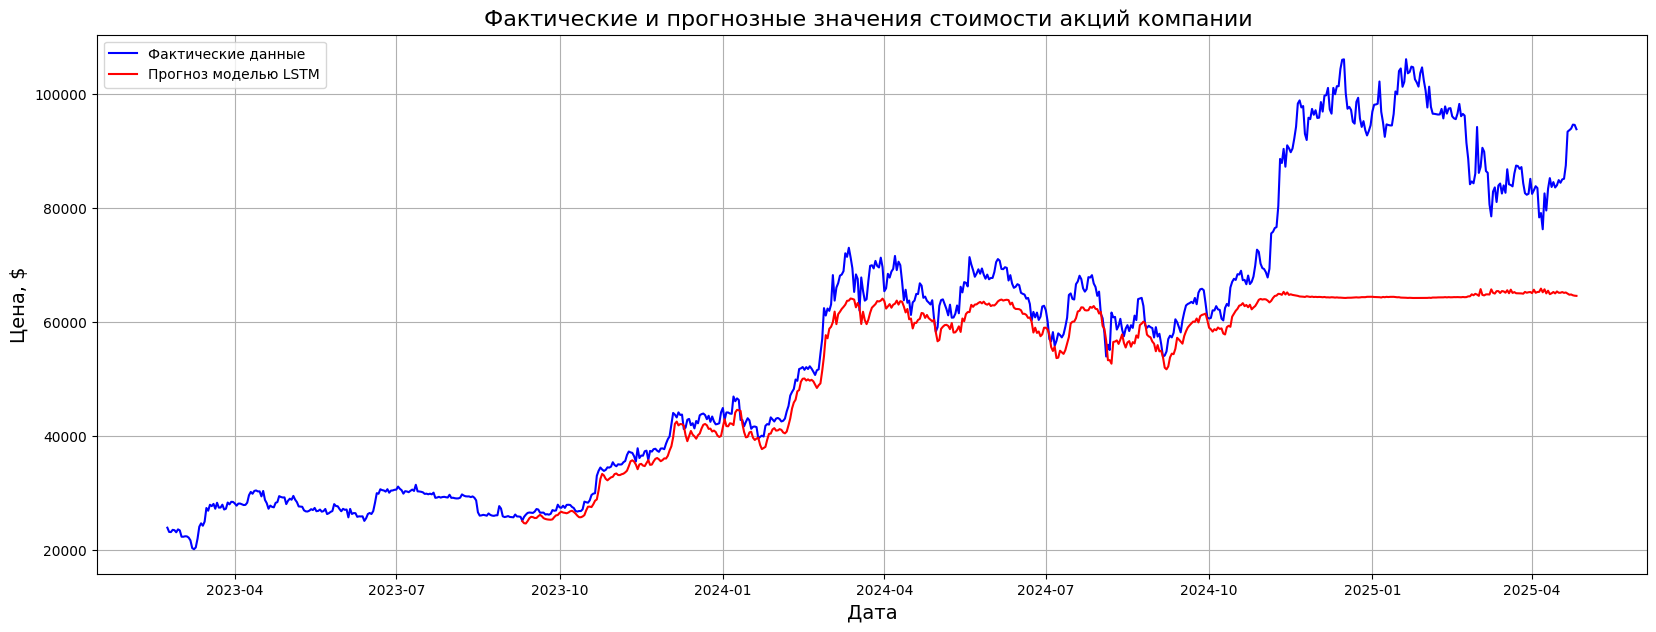

In [20]:
plt.figure(figsize=(20,7))
plt.plot(btc[num_shape-200:].index.values, df_volume[num_shape-200:], color = 'blue', label='Фактические данные')
plt.plot(btc.index[-predict_LSTM.shape[0]:].values, predict_LSTM, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании ', fontsize = 16)
plt.show()

## multifaceted

In [205]:
data = btc.copy()

In [206]:
data = data[['close', 'high', 'low', 'open', 'volume']]

In [236]:
#Data Preprocessing

num_shape = 4000

train = data.iloc[:num_shape]
test = data.iloc[num_shape:]

In [208]:
scalers = {}
for i, col in enumerate(train.columns):
    scalers[col] = MinMaxScaler(feature_range = (0, 1))
    train[col] = scalers[col].fit_transform(train[[col]])

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/945903397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scalers[col].fit_transform(train[[col]])
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/945903397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scalers[col].fit_transform(train[[col]])
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/945903397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [209]:
# Параметры временного окна
LOOK_BACK = 60  # Используем 60 предыдущих свечей
FORECAST = 1    # Прогнозируем следующее значение 'close'

In [210]:
X, y = [], []
for i in range(LOOK_BACK, len(train)-FORECAST):
    X.append(train.values[i-LOOK_BACK:i])  # Все 5 признаков
    y.append(train['close'].values[i:i+FORECAST])  # Прогнозируем 'close'

X = np.array(X)
y = np.array(y)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [177]:
# Initializing the Recurrent Neural Network
model_2 = tensorflow.keras.Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model_2.add(LSTM(units = 128, return_sequences = True, input_shape = (LOOK_BACK, 5)))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units = 64, return_sequences = True))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units = 32, return_sequences = True))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units = 16, return_sequences = True))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units = 8))
model_2.add(Dropout(0.2))


# Adding the output layer
model_2.add(Dense(units = 1))
model_2.summary()

/Users/nikita/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 60, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,377 (524.91 KB)

 Trainable params: 134,377 (524.91 KB)

 Non-trainable params: 0 (0.00 B)

In [178]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

model_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model_2.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0077 - mae: 0.0438
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0023 - mae: 0.0232
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0024 - mae: 0.0245
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0024 - mae: 0.0229
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017 - mae: 0.0206
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0020 - mae: 0.0221
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0021 - mae: 0.0224
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016 - mae: 0.0200
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017 - mae: 0.0214
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0020 - mae: 0.0225
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017 - mae: 0.0211
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - mae: 0.0201
Epoch 13/100
99/99 ━━━━━━

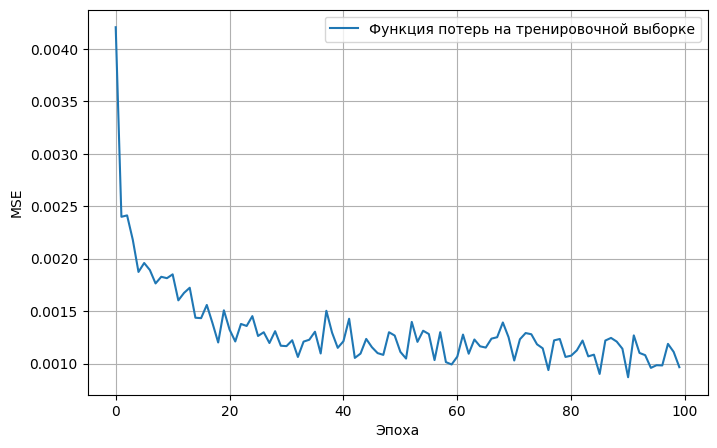

In [179]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['loss'], label='Функция потерь на тренировочной выборке')
#plt.plot(hist.history['val_loss'], label='Функция потерь на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

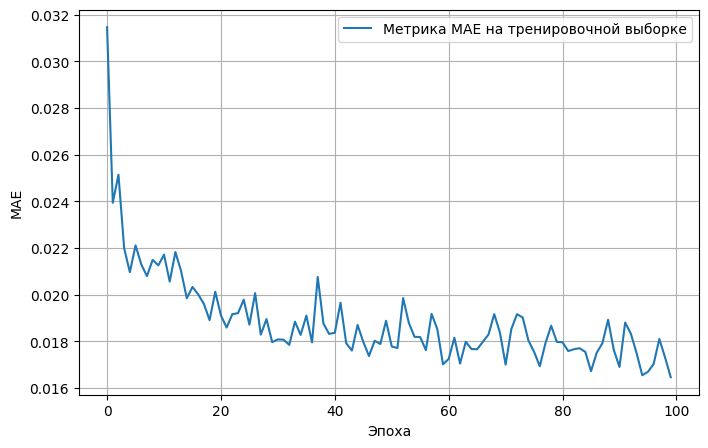

In [180]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['mae'], label='Метрика MAE на тренировочной выборке')
#plt.plot(hist.history['val_mae'], label='Метрика MAE на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [212]:
# Прогнозирование на тестовых данных
y_pred = model_2.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [194]:
scalers

{'close': MinMaxScaler(),
 'high': MinMaxScaler(),
 'low': MinMaxScaler(),
 'open': MinMaxScaler(),
 'volume': MinMaxScaler()}

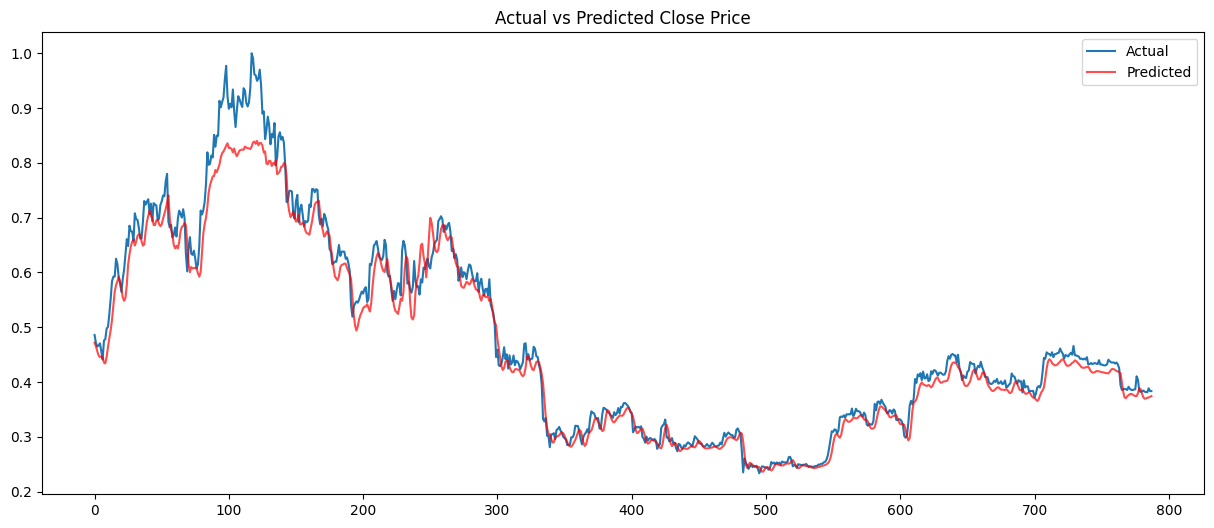

MAE: 0.022786453384495916
RMSE: 0.033724338307354


In [213]:
# Визуализация результатов
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7, color='red')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

# Оценка модели
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

In [237]:
scalers_test = {}
for i, col in enumerate(test.columns):
    scalers_test[col] = MinMaxScaler(feature_range = (0, 1))
    test[col] = scalers_test[col].fit_transform(test[[col]])

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/1518666498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scalers_test[col].fit_transform(test[[col]])
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/1518666498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scalers_test[col].fit_transform(test[[col]])
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_21913/1518666498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

In [238]:
X_x, y_y = [], []
for i in range(LOOK_BACK, len(test)-FORECAST):
    X_x.append(test.values[i-LOOK_BACK:i])  # Все 5 признаков
    y_y.append(test['close'].values[i:i+FORECAST])  # Прогнозируем 'close'

X_x = np.array(X_x)
y_y = np.array(y_y)

In [239]:
predict_LSTM_2 = model_2.predict(X_x)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [243]:
y_y = scalers_test['close'].inverse_transform(y_y)

In [244]:
predict_LSTM_2 = scalers_test['close'].inverse_transform(predict_LSTM_2)

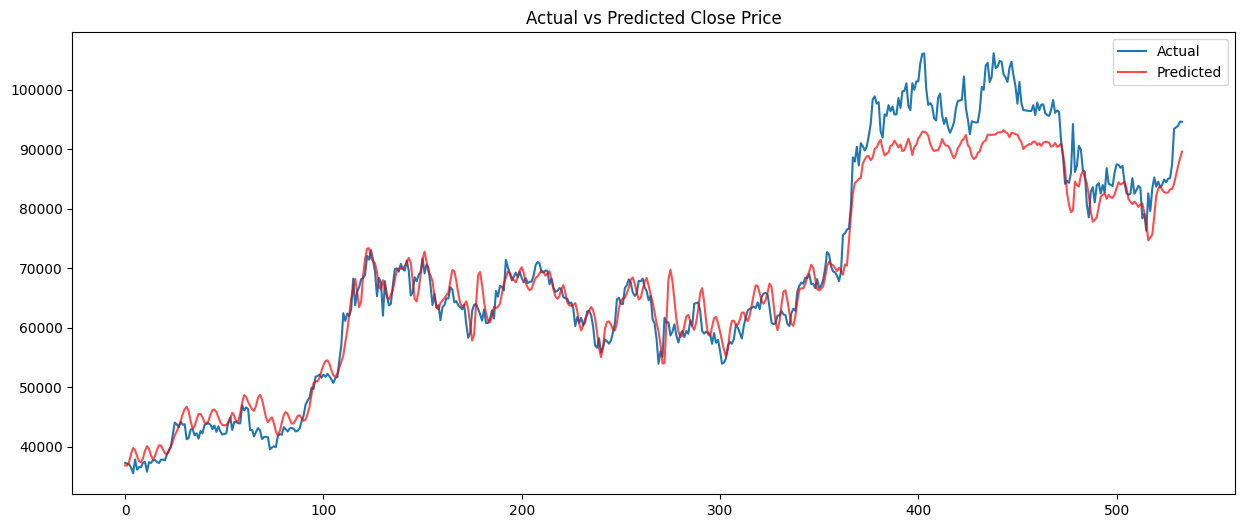

MAE: 3128.030620903558
RMSE: 4264.537184568012


In [246]:
# Визуализация результатов
plt.figure(figsize=(15, 6))
plt.plot(y_y, label='Actual')
plt.plot(predict_LSTM_2, label='Predicted', alpha=0.7, color='red')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

# Оценка модели
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"MAE: {mean_absolute_error(y_y, predict_LSTM_2)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_y, predict_LSTM_2))}")